<a href="https://colab.research.google.com/github/Tanvir220-noob/Attention/blob/main/attention(1.1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!gdown 1-cMO7XFGYCMgdT459ql7heQqDN7e-4oa

Downloading...
From (original): https://drive.google.com/uc?id=1-cMO7XFGYCMgdT459ql7heQqDN7e-4oa
From (redirected): https://drive.google.com/uc?id=1-cMO7XFGYCMgdT459ql7heQqDN7e-4oa&confirm=t&uuid=220488c5-8003-4d6e-848f-5597220d4ed4
To: /content/archive (2).zip
100% 151M/151M [00:01<00:00, 125MB/s]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import zipfile, os

# Example: uploaded coffee-beans.zip
zip_path = "/content/archive (2).zip"
extract_dir = "/content/coffee-beans"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Now base_dir is:
base_dir = extract_dir
print("Base dir:", base_dir)
print("Folders:", os.listdir(base_dir))

Base dir: /content/coffee-beans
Folders: ['Coffee Bean.csv', 'train', 'test']


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score, roc_curve, auc)
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
# ====== CBAM Block ======
def cbam_block(feature_map, ratio=8):
    channel = feature_map.shape[-1]

    # Channel Attention
    shared_dense_one = layers.Dense(channel // ratio, activation='relu',
                                    kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = layers.GlobalAveragePooling2D()(feature_map)
    avg_pool = layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(feature_map)
    max_pool = layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    channel_attention = layers.Add()([avg_pool, max_pool])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_refined = layers.Multiply()([feature_map, channel_attention])

    # Spatial Attention
    avg_pool_sp = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(channel_refined)
    max_pool_sp = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(channel_refined)
    concat = layers.Concatenate(axis=3)([avg_pool_sp, max_pool_sp])
    spatial_attention = layers.Conv2D(1, (7,7), padding='same', activation='sigmoid')(concat)

    refined_feature = layers.Multiply()([channel_refined, spatial_attention])
    return refined_feature

In [19]:
# ====== CBAM-CNN Backbone ======
def build_cbam_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = cbam_block(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = cbam_block(x)

    # Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = cbam_block(x)

    # Head
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dense(256, activation='relu', name="feat_dense")(x)   # <-- features we'll extract
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

In [28]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data directories
train_dir = "/content/coffee-beans/train"
test_dir = "/content/coffee-beans/test"

# ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Final sanity check
print("Train classes mapping:", train_gen.class_indices)
print("Test classes mapping:", test_gen.class_indices)

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Train classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Test classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [30]:
# ====== Train CBAM-CNN ======
# ====== Train CBAM-CNN ======

# get number of classes dynamically from generator
num_classes = train_gen.num_classes

cbam_model = build_cbam_cnn(input_shape=(128,128,3), num_classes=num_classes)

cbam_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = cbam_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=40,
    verbose=1
)

Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 464ms/step - accuracy: 0.2540 - loss: 1.3871 - val_accuracy: 0.2500 - val_loss: 1.3855
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step - accuracy: 0.2718 - loss: 1.3834 - val_accuracy: 0.2500 - val_loss: 1.3163
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.3870 - loss: 1.1494 - val_accuracy: 0.5725 - val_loss: 0.8147
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.6640 - loss: 0.6942 - val_accuracy: 0.7275 - val_loss: 0.6119
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.7263 - loss: 0.5827 - val_accuracy: 0.6900 - val_loss: 0.6356
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.7454 - loss: 0.5629 - val_accuracy: 0.5550 - val_loss: 0.8977
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.7554 - loss: 0.5102 - val_accuracy: 0.5675 - val_loss: 0.9839
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.7566 - loss: 0.4749 - val_accurac

In [31]:
# ====== Feature Extraction ======
feature_extractor = models.Model(
    inputs=cbam_model.input,
    outputs=cbam_model.get_layer("feat_dense").output  # 256-d features
)

X_train = feature_extractor.predict(train_gen, verbose=1)
X_val   = feature_extractor.predict(val_gen, verbose=1)

y_train = train_gen.classes
y_val   = val_gen.classes
unique_classes = np.unique(y_train)


38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


In [32]:
# ====== Random Forest (CV on Train Features) ======
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold = 1
acc_list, auc_list = [], []

for tr_idx, te_idx in kf.split(X_train, y_train):
    X_tr, X_te = X_train[tr_idx], X_train[te_idx]
    y_tr, y_te = y_train[tr_idx], y_train[te_idx]

    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_tr, y_tr)

    y_pred  = rf.predict(X_te)
    y_proba = rf.predict_proba(X_te)

    acc = accuracy_score(y_te, y_pred)
    acc_list.append(acc)

    # Multi-class ROC-AUC (One-vs-Rest)
    y_te_bin = label_binarize(y_te, classes=unique_classes)
    # if a fold is missing a class, skip AUC
    if y_te_bin.shape[1] < num_classes:
        print(f"Fold {fold} - Accuracy: {acc:.4f}, ROC-AUC skipped (not all classes in fold)")
        auc_list.append(np.nan)
    else:
        # Align columns of y_proba to unique_classes order
        # rf.classes_ gives column order in predict_proba
        class_order = rf.classes_
        reorder_idx = [np.where(class_order == c)[0][0] for c in unique_classes]
        y_proba_ordered = y_proba[:, reorder_idx]

        auc_score = roc_auc_score(y_te_bin, y_proba_ordered, multi_class='ovr')
        auc_list.append(auc_score)
        print(f"Fold {fold} - Accuracy: {acc:.4f}, AUC: {auc_score:.4f}")

    fold += 1
    print("Mean CV Accuracy:", np.nanmean(acc_list))
print("Mean CV AUC:", np.nanmean(auc_list))

Fold 1 - Accuracy: 0.2600, AUC: 0.5261
Mean CV Accuracy: 0.26
Fold 2 - Accuracy: 0.2500, AUC: 0.4624
Mean CV Accuracy: 0.255
Fold 3 - Accuracy: 0.2525, AUC: 0.4914
Mean CV Accuracy: 0.25416666666666665
Mean CV AUC: 0.49328194444444445


In [33]:
# ====== Train RF on Full Train Features & Evaluate on Validation ======
rf_final = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)
rf_final.fit(X_train, y_train)

y_val_pred  = rf_final.predict(X_val)
y_val_proba = rf_final.predict_proba(X_val)

print("\n=== Validation Metrics ===")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision (macro):", precision_score(y_val, y_val_pred, average='macro'))
print("Recall (macro):", recall_score(y_val, y_val_pred, average='macro'))
print("F1-score (macro):", f1_score(y_val, y_val_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))


=== Validation Metrics ===
Accuracy: 0.39166666666666666
Precision (macro): 0.39515425070483623
Recall (macro): 0.39166666666666666
F1-score (macro): 0.3848531093853471
Confusion Matrix:
 [[36 13  4  7]
 [20 20  6 14]
 [ 8 20 19 13]
 [23  7 11 19]]


Accuracy: 0.39166666666666666
Precision: 0.39515425070483623
Recall: 0.39166666666666666
F1-score: 0.3848531093853471
Confusion Matrix:
 [[36 13  4  7]
 [20 20  6 14]
 [ 8 20 19 13]
 [23  7 11 19]]
Validation AUC (OvR): 0.6713310185185186


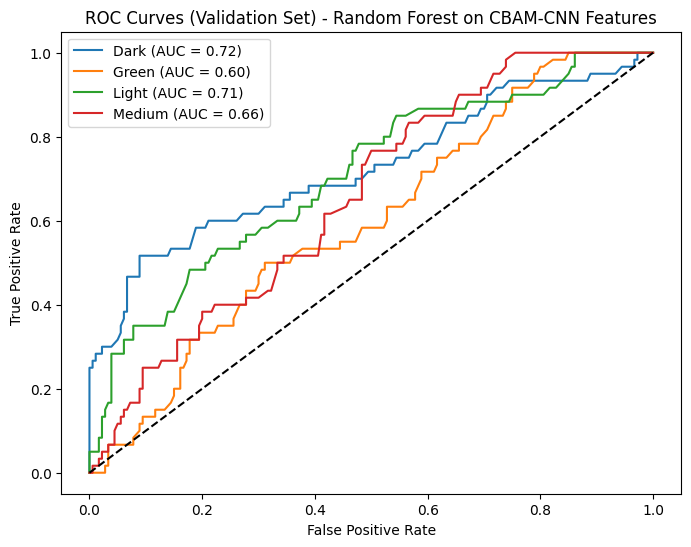

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# ====== Validation metrics ======
y_val_pred = rf_final.predict(X_val)
y_val_proba = rf_final.predict_proba(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, average='macro'))
print("Recall:", recall_score(y_val, y_val_pred, average='macro'))
print("F1-score:", f1_score(y_val, y_val_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# ====== ROC-AUC ======
unique_classes = np.unique(y_val)  # ensure consistent ordering
y_val_bin = label_binarize(y_val, classes=unique_classes)

if y_val_bin.shape[1] < len(unique_classes):
    print("ROC-AUC skipped: not all classes present in validation set")
else:
    # Reorder probability columns to match unique_classes
    class_order = rf_final.classes_
    reorder_idx = [np.where(class_order == c)[0][0] for c in unique_classes]
    y_val_proba_ordered = y_val_proba[:, reorder_idx]

    val_auc = roc_auc_score(y_val_bin, y_val_proba_ordered, multi_class='ovr')
    print("Validation AUC (OvR):", val_auc)

    # ====== ROC Curves (per class) ======
    # Create int -> class label mapping
    idx_to_class = {v:k for k,v in train_gen.class_indices.items()}  # 0->'Dark', etc.

    plt.figure(figsize=(8,6))
    for i, cls in enumerate(unique_classes):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_proba_ordered[:, i])
        plt.plot(fpr, tpr, label=f"{idx_to_class[cls]} (AUC = {auc(fpr, tpr):.2f})")

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Validation Set) - Random Forest on CBAM-CNN Features")
    plt.legend()
    plt.show()